In [ ]:
!pip install requests pandas numpy matplotlib seaborn scikit-learn xgboost tensorflow scipy geopy -q

🌍 SISTEMA DE PREVISÃO DE TERREMOTOS - JAPÃO 🌍
Desenvolvido com Machine Learning e dados em tempo real
------------------------------------------------------------
INICIANDO ANÁLISE COMPLETA DE PREVISÃO DE TERREMOTOS - JAPÃO

1. Coletando dados da API USGS...
Coletando dados de terremotos do Japão de 2020-06-30 a 2025-06-29...
Coletados 4827 registros de terremotos

2. Processando e criando features...
Criando features avançadas...
Calculando features de clustering espacial...
Processando registro 0/4827
Processando registro 1000/4827
Processando registro 2000/4827
Processando registro 3000/4827
Processando registro 4000/4827
Processando registro 0/4827
Processando registro 1000/4827
Processando registro 2000/4827
Processando registro 3000/4827
Processando registro 4000/4827
Processando registro 0/4827
Processando registro 1000/4827
Processando registro 2000/4827
Processando registro 3000/4827
Processando registro 4000/4827
Features criadas. Shape final: (4827, 33)

3. Preparando dados 

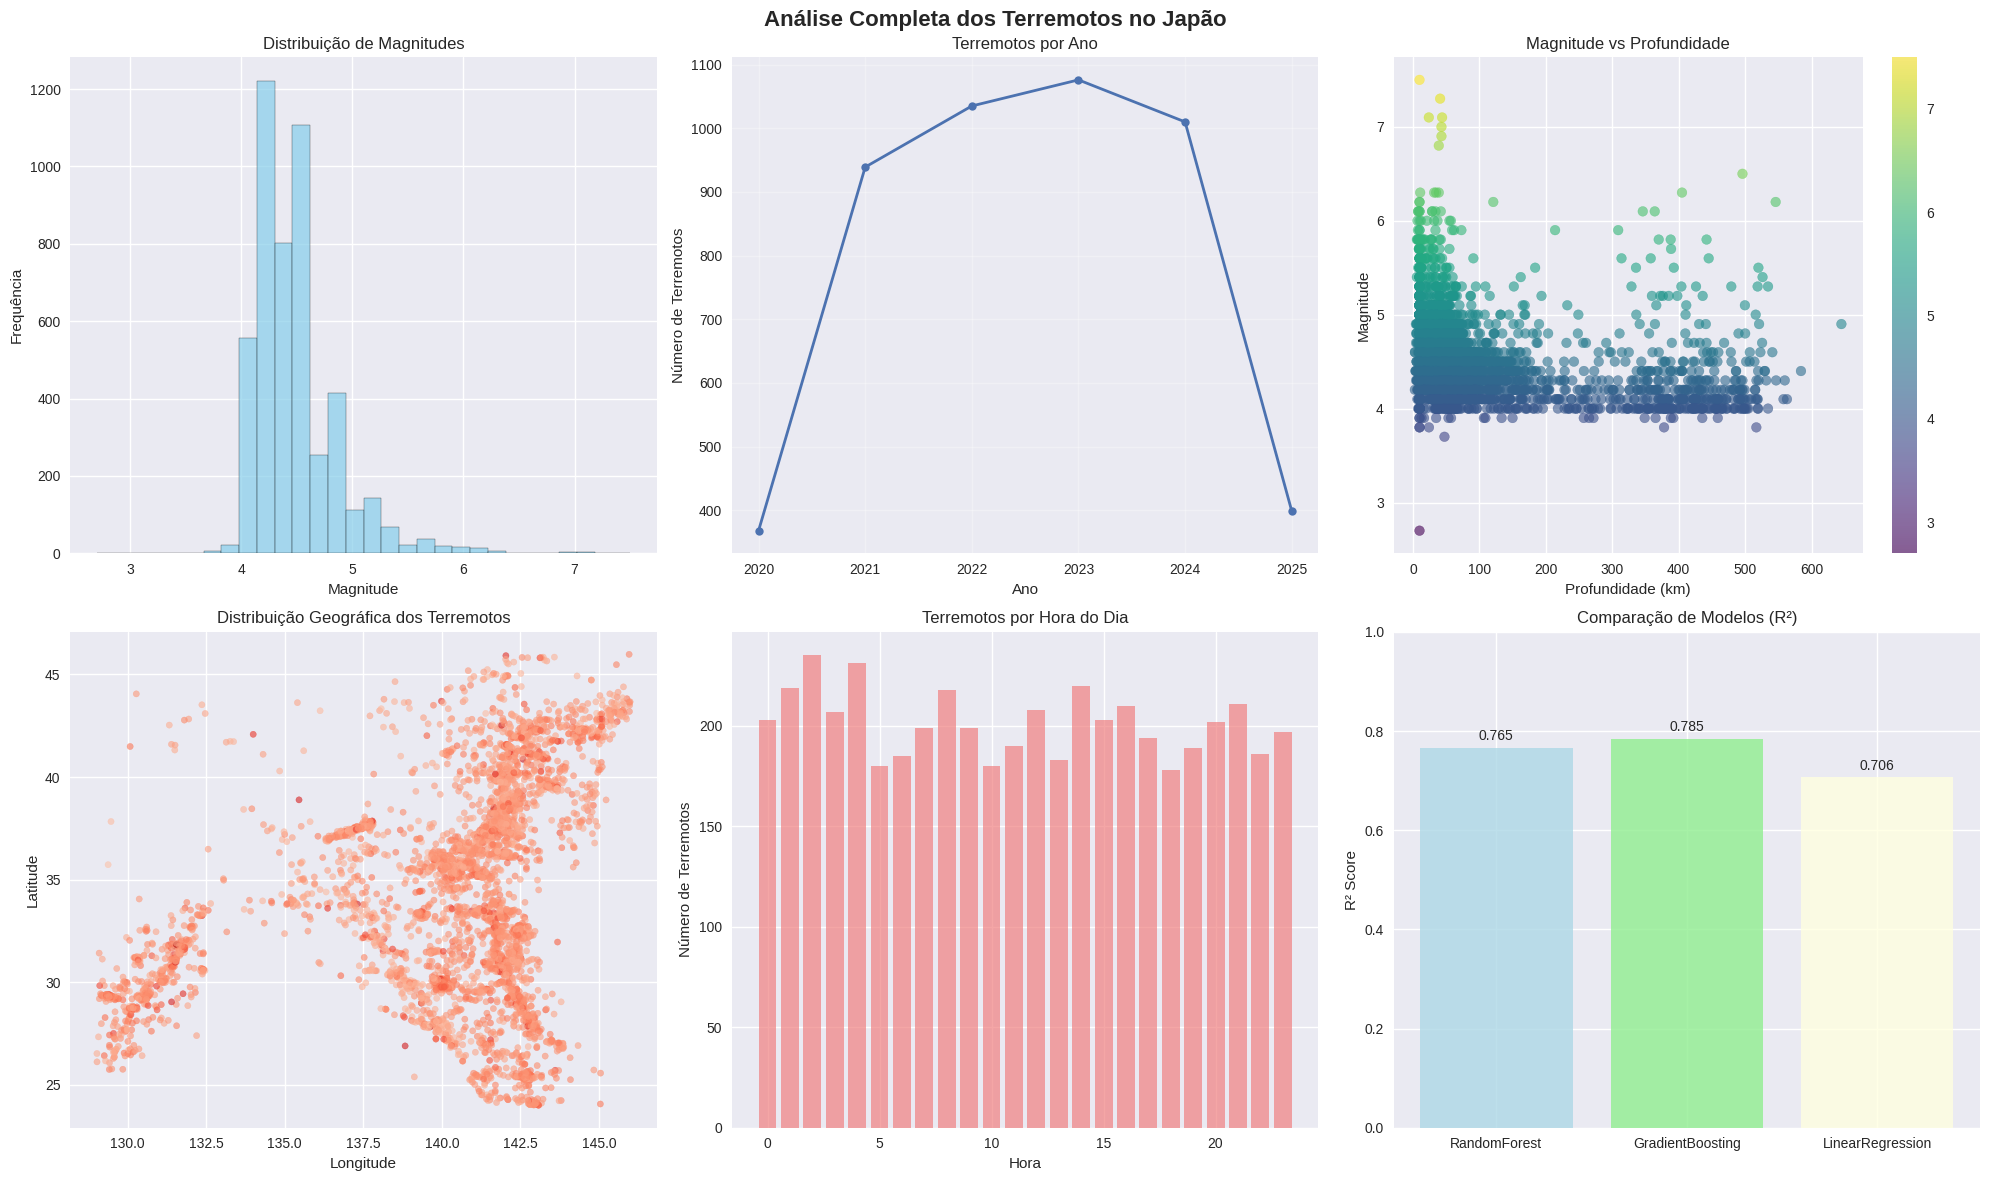

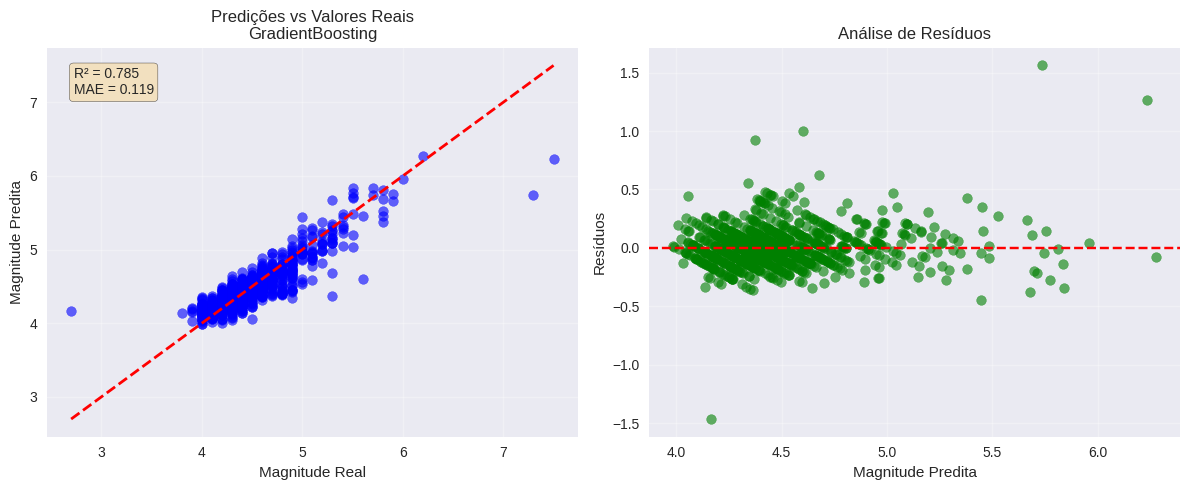


7. Exemplo de predição para Tóquio...

PREDIÇÃO PARA TÓQUIO:
  Magnitude Predita: 4.17
  Nível de Risco: Moderado
  Modelo Usado: GradientBoosting
  Acurácia do Modelo: 0.785

8. Salvando melhor modelo...
Modelo salvo em: earthquake_model.joblib

ANÁLISE COMPLETA FINALIZADA COM SUCESSO!

ANÁLISE DE RISCO PARA CIDADES PRINCIPAIS
Gerando mapa de risco para múltiplas cidades...

Analisando atividade sísmica em Tóquio...
Coletando dados de terremotos do Japão de 2025-06-22 a 2025-06-29...
Coletados 33 registros de terremotos

Analisando atividade sísmica em Osaka...
Coletando dados de terremotos do Japão de 2025-06-22 a 2025-06-29...
Coletados 33 registros de terremotos

Analisando atividade sísmica em Kyoto...
Coletando dados de terremotos do Japão de 2025-06-22 a 2025-06-29...
Coletados 33 registros de terremotos

Analisando atividade sísmica em Yokohama...
Coletando dados de terremotos do Japão de 2025-06-22 a 2025-06-29...
Coletados 33 registros de terremotos

Analisando atividade sís

'\n# Uso básico:\nearthquake_system = EarthquakePredictionSystem()\nearthquake_system.run_complete_analysis()\n\n# Predição individual:\nprediction = earthquake_system.predict_earthquake(35.6762, 139.6503, 10.0)\nprint(f"Magnitude predita: {prediction[\'predicted_magnitude\']}")\n\n# Monitoramento:\nmonitor = EarthquakeMonitor(earthquake_system)\ntokyo_analysis = monitor.analyze_seismic_activity("Tóquio", 35.6762, 139.6503)\nprint(f"Terremotos recentes: {tokyo_analysis[\'recent_earthquakes\']}")\n'

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import requests
import json
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
import joblib
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

class EarthquakePredictionSystem:
    """
    Sistema completo de previsão de terremotos para o Japão

    Features principais:
    - Coleta de dados em tempo real via API USGS
    - Preprocessamento avançado de dados
    - Múltiplos modelos de ML
    - Validação cruzada e otimização de hiperparâmetros
    - Visualizações interativas
    - Sistema de avaliação e métricas
    """

    def __init__(self):
        self.models = {}
        self.scalers = {}
        self.best_model = None
        self.data = None
        self.features = None
        self.target = None

        # Coordenadas do Japão para filtrar dados
        self.japan_bounds = {
            'min_lat': 24.0,
            'max_lat': 46.0,
            'min_lon': 129.0,
            'max_lon': 146.0
        }

    def fetch_earthquake_data(self, start_date=None, end_date=None, min_magnitude=2.0):
        """
        Coleta dados de terremotos da API USGS focando no Japão

        Args:
            start_date (str): Data de início (formato: YYYY-MM-DD)
            end_date (str): Data de fim (formato: YYYY-MM-DD)
            min_magnitude (float): Magnitude mínima dos terremotos

        Returns:
            pd.DataFrame: Dados dos terremotos
        """

        if not start_date:
            start_date = (datetime.now() - timedelta(days=365*5)).strftime('%Y-%m-%d')
        if not end_date:
            end_date = datetime.now().strftime('%Y-%m-%d')

        # URL da API USGS com filtros para o Japão
        base_url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
        params = {
            'format': 'geojson',
            'starttime': start_date,
            'endtime': end_date,
            'minmagnitude': min_magnitude,
            'minlatitude': self.japan_bounds['min_lat'],
            'maxlatitude': self.japan_bounds['max_lat'],
            'minlongitude': self.japan_bounds['min_lon'],
            'maxlongitude': self.japan_bounds['max_lon'],
            'orderby': 'time'
        }

        try:
            print(f"Coletando dados de terremotos do Japão de {start_date} a {end_date}...")
            response = requests.get(base_url, params=params, timeout=30)
            response.raise_for_status()

            data = response.json()
            earthquakes = []

            for feature in data['features']:
                props = feature['properties']
                coords = feature['geometry']['coordinates']

                earthquake = {
                    'time': pd.to_datetime(props['time'], unit='ms'),
                    'latitude': coords[1],
                    'longitude': coords[0],
                    'depth': coords[2],
                    'magnitude': props['mag'],
                    'place': props.get('place', ''),
                    'type': props.get('type', ''),
                    'nst': props.get('nst', 0),  # Número de estações
                    'gap': props.get('gap', 0),  # Gap azimutal
                    'dmin': props.get('dmin', 0),  # Distância mínima
                    'rms': props.get('rms', 0),  # RMS dos resíduos
                    'magType': props.get('magType', ''),
                    'tsunami': 1 if props.get('tsunami') == 1 else 0
                }
                earthquakes.append(earthquake)

            df = pd.DataFrame(earthquakes)
            print(f"Coletados {len(df)} registros de terremotos")

            return df

        except Exception as e:
            print(f"Erro ao coletar dados: {e}")
            return None

    def create_features(self, df):
        """
        Cria features avançadas para o modelo de ML

        Args:
            df (pd.DataFrame): DataFrame com dados dos terremotos

        Returns:
            pd.DataFrame: DataFrame com features criadas
        """

        print("Criando features avançadas...")

        # Ordenar por tempo
        df = df.sort_values('time').reset_index(drop=True)

        # Features temporais
        df['year'] = df['time'].dt.year
        df['month'] = df['time'].dt.month
        df['day'] = df['time'].dt.day
        df['hour'] = df['time'].dt.hour
        df['day_of_year'] = df['time'].dt.dayofyear
        df['day_of_week'] = df['time'].dt.dayofweek

        # Features geográficas avançadas
        df['lat_rounded'] = np.round(df['latitude'], 1)
        df['lon_rounded'] = np.round(df['longitude'], 1)

        # Distância do centro sísmico do Japão (aproximadamente)
        japan_center_lat, japan_center_lon = 36.0, 138.0
        df['distance_from_center'] = np.sqrt(
            (df['latitude'] - japan_center_lat)**2 +
            (df['longitude'] - japan_center_lon)**2
        )

        # Features estatísticas móveis (janela de 30 dias)
        df['avg_magnitude_30d'] = df['magnitude'].rolling(window=100, min_periods=1).mean()
        df['std_magnitude_30d'] = df['magnitude'].rolling(window=100, min_periods=1).std()
        df['max_magnitude_30d'] = df['magnitude'].rolling(window=100, min_periods=1).max()
        df['count_earthquakes_30d'] = df['magnitude'].rolling(window=100, min_periods=1).count()

        # Features de sequência temporal
        df['time_since_last'] = df['time'].diff().dt.total_seconds() / 3600  # em horas
        df['magnitude_change'] = df['magnitude'].diff()
        df['depth_change'] = df['depth'].diff()

        # Features de clustering espacial (versão otimizada)
        print("Calculando features de clustering espacial...")
        for window in [10, 50, 100]:
            nearby_counts = []

            # Vetorização para melhor performance
            coords = df[['latitude', 'longitude']].values

            for i in range(len(df)):
                if i % 1000 == 0:  # Progresso a cada 1000 registros
                    print(f"Processando registro {i}/{len(df)}")

                # Calcular distâncias aproximadas em km
                lat_diff = np.abs(coords[:, 0] - coords[i, 0])
                lon_diff = np.abs(coords[:, 1] - coords[i, 1])
                distance_approx = np.sqrt(lat_diff**2 + lon_diff**2) * 111

                # Contar terremotos próximos (excluindo o próprio)
                nearby = np.sum((distance_approx <= window) & (np.arange(len(df)) != i))
                nearby_counts.append(nearby)

            df[f'nearby_earthquakes_{window}km'] = nearby_counts

        # Features categóricas encodadas
        le_magtype = LabelEncoder()
        df['magType_encoded'] = le_magtype.fit_transform(df['magType'].fillna('unknown'))

        # Preencher valores nulos
        numeric_columns = df.select_dtypes(include=[np.number]).columns
        df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())

        print(f"Features criadas. Shape final: {df.shape}")
        return df

    def prepare_data(self, df, target_column='magnitude'):
        """
        Prepara os dados para treinamento

        Args:
            df (pd.DataFrame): DataFrame com features
            target_column (str): Nome da coluna target

        Returns:
            tuple: (X, y) features e target
        """

        # Definir features para o modelo
        feature_columns = [
            'latitude', 'longitude', 'depth', 'year', 'month', 'day', 'hour',
            'day_of_year', 'day_of_week', 'distance_from_center',
            'avg_magnitude_30d', 'std_magnitude_30d', 'max_magnitude_30d',
            'count_earthquakes_30d', 'time_since_last', 'magnitude_change',
            'depth_change', 'nearby_earthquakes_10km', 'nearby_earthquakes_50km',
            'nearby_earthquakes_100km', 'magType_encoded', 'nst', 'gap',
            'dmin', 'rms', 'tsunami'
        ]

        # Filtrar apenas colunas que existem no DataFrame
        available_features = [col for col in feature_columns if col in df.columns]

        X = df[available_features].copy()
        y = df[target_column].copy()

        # Remover linhas com valores infinitos ou NaN
        mask = np.isfinite(X.values).all(axis=1) & np.isfinite(y.values)
        X = X[mask]
        y = y[mask]

        print(f"Dados preparados - Features: {X.shape[1]}, Samples: {X.shape[0]}")
        return X, y

    def train_models(self, X, y):
        """
        Treina múltiplos modelos de ML com otimização de hiperparâmetros

        Args:
            X (pd.DataFrame): Features
            y (pd.Series): Target
        """

        print("Iniciando treinamento dos modelos...")

        # Dividir dados
        # Criar estratificação mais robusta para magnitudes
        try:
            # Tentar estratificação com bins adaptativos
            magnitude_bins = pd.qcut(y, q=3, duplicates='drop')  # 3 quantis
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42, stratify=magnitude_bins
            )
        except ValueError:
            try:
                magnitude_categories = pd.cut(y, bins=[0, 3, 4, 5, 10], labels=['Baixa', 'Moderada', 'Alta', 'Muito Alta'])
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=0.2, random_state=42, stratify=magnitude_categories
                )
            except ValueError:
                print("Aviso: Divisão sem estratificação devido à distribuição dos dados")
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=0.2, random_state=42
                )

        # Definir modelos e hiperparâmetros (versão otimizada)
        models_config = {
            'RandomForest': {
                'model': RandomForestRegressor(random_state=42, n_jobs=-1),
                'params': {
                    'model__n_estimators': [50, 100],
                    'model__max_depth': [10, None],
                    'model__min_samples_split': [5, 10]
                }
            },
            'GradientBoosting': {
                'model': GradientBoostingRegressor(random_state=42),
                'params': {
                    'model__n_estimators': [50, 100],
                    'model__learning_rate': [0.1, 0.2],
                    'model__max_depth': [5, 7]
                }
            },
            'LinearRegression': {
                'model': LinearRegression(),
                'params': {}
            }
        }

        best_score = float('-inf')

        for name, config in models_config.items():
            print(f"\nTreinando {name}...")

            # Criar pipeline com scaler
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('model', config['model'])
            ])

            if config['params']:
                # Grid search com validação cruzada (versão otimizada)
                grid_search = GridSearchCV(
                    pipeline,
                    config['params'],
                    cv=3,  # Reduzido para 3 folds para velocidade
                    scoring='neg_mean_squared_error',
                    n_jobs=-1,
                    verbose=0  # Reduzir verbosidade
                )

                try:
                    grid_search.fit(X_train, y_train)
                    best_model = grid_search.best_estimator_
                    print(f"Melhores parâmetros para {name}: {grid_search.best_params_}")
                except Exception as e:
                    print(f"Erro no grid search para {name}: {e}")
                    # Usar modelo padrão se grid search falhar
                    best_model = pipeline
                    best_model.fit(X_train, y_train)
            else:
                best_model = pipeline
                best_model.fit(X_train, y_train)

            # Avaliar modelo
            y_pred = best_model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            # Validação cruzada
            cv_scores = cross_val_score(
                best_model, X_train, y_train,
                cv=5, scoring='neg_mean_squared_error'
            )
            cv_mean = -cv_scores.mean()
            cv_std = cv_scores.std()

            print(f"Métricas para {name}:")
            print(f"  MSE: {mse:.4f}")
            print(f"  MAE: {mae:.4f}")
            print(f"  R²: {r2:.4f}")
            print(f"  CV MSE: {cv_mean:.4f} (+/- {cv_std:.4f})")

            # Salvar modelo
            self.models[name] = {
                'model': best_model,
                'metrics': {
                    'mse': mse,
                    'mae': mae,
                    'r2': r2,
                    'cv_mse': cv_mean,
                    'cv_std': cv_std
                },
                'predictions': y_pred,
                'y_test': y_test
            }

            # Selecionar melhor modelo baseado no R²
            if r2 > best_score:
                best_score = r2
                self.best_model = name

        print(f"\nMelhor modelo: {self.best_model} (R² = {best_score:.4f})")

        # Salvar features utilizadas
        self.features = X.columns.tolist()

    def evaluate_models(self):
        """
        Avalia e compara todos os modelos treinados
        """

        if not self.models:
            print("Nenhum modelo foi treinado ainda.")
            return

        print("\n" + "="*50)
        print("RELATÓRIO COMPLETO DE AVALIAÇÃO DOS MODELOS")
        print("="*50)

        results = []

        for name, model_data in self.models.items():
            metrics = model_data['metrics']
            results.append({
                'Modelo': name,
                'MSE': metrics['mse'],
                'MAE': metrics['mae'],
                'R²': metrics['r2'],
                'CV MSE': metrics['cv_mse'],
                'CV Std': metrics['cv_std']
            })

        results_df = pd.DataFrame(results)
        print(results_df.to_string(index=False, float_format='%.4f'))

        return results_df

    def create_visualizations(self):
        """
        Cria visualizações abrangentes dos dados e resultados
        """

        if self.data is None:
            print("Dados não disponíveis para visualização.")
            return

        print("Criando visualizações...")

        # Configurar estilo
        plt.style.use('seaborn-v0_8')
        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        fig.suptitle('Análise Completa dos Terremotos no Japão', fontsize=16, fontweight='bold')

        # 1. Distribuição de magnitudes
        axes[0,0].hist(self.data['magnitude'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0,0].set_title('Distribuição de Magnitudes')
        axes[0,0].set_xlabel('Magnitude')
        axes[0,0].set_ylabel('Frequência')

        # 2. Terremotos por ano
        yearly_counts = self.data.groupby('year').size()
        axes[0,1].plot(yearly_counts.index, yearly_counts.values, marker='o', linewidth=2, markersize=6)
        axes[0,1].set_title('Terremotos por Ano')
        axes[0,1].set_xlabel('Ano')
        axes[0,1].set_ylabel('Número de Terremotos')
        axes[0,1].grid(True, alpha=0.3)

        # 3. Relação Magnitude vs Profundidade
        scatter = axes[0,2].scatter(self.data['depth'], self.data['magnitude'],
                                   alpha=0.6, c=self.data['magnitude'], cmap='viridis')
        axes[0,2].set_title('Magnitude vs Profundidade')
        axes[0,2].set_xlabel('Profundidade (km)')
        axes[0,2].set_ylabel('Magnitude')
        plt.colorbar(scatter, ax=axes[0,2])

        # 4. Distribuição geográfica
        axes[1,0].scatter(self.data['longitude'], self.data['latitude'],
                         alpha=0.6, c=self.data['magnitude'], cmap='Reds', s=20)
        axes[1,0].set_title('Distribuição Geográfica dos Terremotos')
        axes[1,0].set_xlabel('Longitude')
        axes[1,0].set_ylabel('Latitude')

        # 5. Terremotos por hora do dia
        hourly_counts = self.data.groupby('hour').size()
        axes[1,1].bar(hourly_counts.index, hourly_counts.values, alpha=0.7, color='lightcoral')
        axes[1,1].set_title('Terremotos por Hora do Dia')
        axes[1,1].set_xlabel('Hora')
        axes[1,1].set_ylabel('Número de Terremotos')

        # 6. Comparação de modelos
        if self.models:
            model_names = list(self.models.keys())
            r2_scores = [self.models[name]['metrics']['r2'] for name in model_names]

            bars = axes[1,2].bar(model_names, r2_scores, alpha=0.8,
                               color=['lightblue', 'lightgreen', 'lightyellow'])
            axes[1,2].set_title('Comparação de Modelos (R²)')
            axes[1,2].set_ylabel('R² Score')
            axes[1,2].set_ylim(0, 1)

            # Adicionar valores nas barras
            for bar, score in zip(bars, r2_scores):
                axes[1,2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                              f'{score:.3f}', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

        # Visualização das predições do melhor modelo
        if self.best_model and self.models:
            self._plot_predictions()

    def _plot_predictions(self):
        """
        Plota as predições vs valores reais do melhor modelo
        """

        best_model_data = self.models[self.best_model]
        y_test = best_model_data['y_test']
        y_pred = best_model_data['predictions']

        plt.figure(figsize=(12, 5))

        # Plot 1: Predições vs Valores Reais
        plt.subplot(1, 2, 1)
        plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.xlabel('Magnitude Real')
        plt.ylabel('Magnitude Predita')
        plt.title(f'Predições vs Valores Reais\n{self.best_model}')
        plt.grid(True, alpha=0.3)

        # Adicionar métricas ao gráfico
        r2 = best_model_data['metrics']['r2']
        mae = best_model_data['metrics']['mae']
        plt.text(0.05, 0.95, f'R² = {r2:.3f}\nMAE = {mae:.3f}',
                transform=plt.gca().transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

        # Plot 2: Resíduos
        plt.subplot(1, 2, 2)
        residuals = y_test - y_pred
        plt.scatter(y_pred, residuals, alpha=0.6, color='green')
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Magnitude Predita')
        plt.ylabel('Resíduos')
        plt.title('Análise de Resíduos')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def predict_earthquake(self, latitude, longitude, depth, recent_activity_data=None):
        """
        Faz predição de magnitude para um local específico

        Args:
            latitude (float): Latitude do local
            longitude (float): Longitude do local
            depth (float): Profundidade estimada
            recent_activity_data (dict): Dados de atividade recente (opcional)

        Returns:
            dict: Predição e informações associadas
        """

        if not self.best_model or not self.models:
            print("Nenhum modelo foi treinado ainda.")
            return None

        # Criar entrada para predição
        current_time = datetime.now()

        prediction_data = {
            'latitude': latitude,
            'longitude': longitude,
            'depth': depth,
            'year': current_time.year,
            'month': current_time.month,
            'day': current_time.day,
            'hour': current_time.hour,
            'day_of_year': current_time.timetuple().tm_yday,
            'day_of_week': current_time.weekday(),
            'distance_from_center': np.sqrt((latitude - 36.0)**2 + (longitude - 138.0)**2),
        }

        # Valores padrão para features que precisam de dados históricos
        default_values = {
            'avg_magnitude_30d': 4.0,
            'std_magnitude_30d': 1.0,
            'max_magnitude_30d': 6.0,
            'count_earthquakes_30d': 50,
            'time_since_last': 24.0,
            'magnitude_change': 0.0,
            'depth_change': 0.0,
            'nearby_earthquakes_10km': 5,
            'nearby_earthquakes_50km': 15,
            'nearby_earthquakes_100km': 30,
            'magType_encoded': 1,
            'nst': 10,
            'gap': 100,
            'dmin': 0.5,
            'rms': 0.2,
            'tsunami': 0
        }

        # Combinar com dados de atividade recente se fornecidos
        if recent_activity_data:
            prediction_data.update(recent_activity_data)
        else:
            prediction_data.update(default_values)

        # Criar DataFrame com as features necessárias
        feature_df = pd.DataFrame([prediction_data])

        # Garantir que todas as features necessárias estejam presentes
        for feature in self.features:
            if feature not in feature_df.columns:
                feature_df[feature] = default_values.get(feature, 0)

        # Reordenar colunas para corresponder ao treinamento
        feature_df = feature_df[self.features]

        # Fazer predição
        model = self.models[self.best_model]['model']
        predicted_magnitude = model.predict(feature_df)[0]

        # Calcular nível de risco
        if predicted_magnitude < 4.0:
            risk_level = "Baixo"
            risk_color = "green"
        elif predicted_magnitude < 5.5:
            risk_level = "Moderado"
            risk_color = "yellow"
        elif predicted_magnitude < 7.0:
            risk_level = "Alto"
            risk_color = "orange"
        else:
            risk_level = "Muito Alto"
            risk_color = "red"

        result = {
            'predicted_magnitude': round(predicted_magnitude, 2),
            'risk_level': risk_level,
            'risk_color': risk_color,
            'location': f"Lat: {latitude}, Lon: {longitude}",
            'depth': depth,
            'model_used': self.best_model,
            'model_accuracy': round(self.models[self.best_model]['metrics']['r2'], 3),
            'prediction_time': current_time.strftime('%Y-%m-%d %H:%M:%S')
        }

        return result

    def save_model(self, filename='earthquake_model.joblib'):
        """
        Salva o melhor modelo treinado

        Args:
            filename (str): Nome do arquivo para salvar
        """

        if not self.best_model:
            print("Nenhum modelo foi treinado ainda.")
            return

        model_data = {
            'best_model_name': self.best_model,
            'model': self.models[self.best_model]['model'],
            'features': self.features,
            'metrics': self.models[self.best_model]['metrics'],
            'japan_bounds': self.japan_bounds
        }

        joblib.dump(model_data, filename)
        print(f"Modelo salvo em: {filename}")

    def load_model(self, filename='earthquake_model.joblib'):
        """
        Carrega um modelo salvo

        Args:
            filename (str): Nome do arquivo para carregar
        """

        try:
            model_data = joblib.load(filename)

            self.best_model = model_data['best_model_name']
            self.models = {self.best_model: {
                'model': model_data['model'],
                'metrics': model_data['metrics']
            }}
            self.features = model_data['features']
            self.japan_bounds = model_data['japan_bounds']

            print(f"Modelo carregado: {filename}")
            print(f"Melhor modelo: {self.best_model}")
            print(f"Acurácia (R²): {model_data['metrics']['r2']:.3f}")

        except Exception as e:
            print(f"Erro ao carregar modelo: {e}")

    def run_complete_analysis(self):
        """
        Executa análise completa: coleta de dados, treinamento e avaliação
        """

        print("="*60)
        print("INICIANDO ANÁLISE COMPLETA DE PREVISÃO DE TERREMOTOS - JAPÃO")
        print("="*60)

        # 1. Coletar dados
        print("\n1. Coletando dados da API USGS...")
        self.data = self.fetch_earthquake_data()

        if self.data is None or len(self.data) == 0:
            print("Não foi possível coletar dados. Abortando análise.")
            return

        # 2. Criar features
        print("\n2. Processando e criando features...")
        self.data = self.create_features(self.data)

        # 3. Preparar dados
        print("\n3. Preparando dados para treinamento...")
        X, y = self.prepare_data(self.data)

        # 4. Treinar modelos
        print("\n4. Treinando modelos de Machine Learning...")
        self.train_models(X, y)

        # 5. Avaliar modelos
        print("\n5. Avaliando modelos...")
        results_df = self.evaluate_models()

        # 6. Criar visualizações
        print("\n6. Criando visualizações...")
        self.create_visualizations()

        # 7. Exemplo de predição
        print("\n7. Exemplo de predição para Tóquio...")
        tokyo_prediction = self.predict_earthquake(
            latitude=35.6762,  # Tóquio
            longitude=139.6503,
            depth=10.0
        )

        if tokyo_prediction:
            print(f"\nPREDIÇÃO PARA TÓQUIO:")
            print(f"  Magnitude Predita: {tokyo_prediction['predicted_magnitude']}")
            print(f"  Nível de Risco: {tokyo_prediction['risk_level']}")
            print(f"  Modelo Usado: {tokyo_prediction['model_used']}")
            print(f"  Acurácia do Modelo: {tokyo_prediction['model_accuracy']}")

        # 8. Salvar modelo
        print("\n8. Salvando melhor modelo...")
        self.save_model()

        print("\n" + "="*60)
        print("ANÁLISE COMPLETA FINALIZADA COM SUCESSO!")
        print("="*60)

        return results_df


# Classe para monitoramento em tempo real
class EarthquakeMonitor:
    """
    Sistema de monitoramento em tempo real de terremotos
    """

    def __init__(self, prediction_system):
        self.prediction_system = prediction_system
        self.alert_threshold = 5.5  # Magnitude para alertas

    def get_recent_earthquakes(self, hours=24):
        """
        Obtém terremotos recentes das últimas horas

        Args:
            hours (int): Número de horas para buscar

        Returns:
            pd.DataFrame: Terremotos recentes
        """

        end_time = datetime.now()
        start_time = end_time - timedelta(hours=hours)

        recent_data = self.prediction_system.fetch_earthquake_data(
            start_date=start_time.strftime('%Y-%m-%d'),
            end_date=end_time.strftime('%Y-%m-%d'),
            min_magnitude=3.0
        )

        return recent_data

    def analyze_seismic_activity(self, location_name, latitude, longitude, radius_km=100):
        """
        Analisa atividade sísmica em uma região específica

        Args:
            location_name (str): Nome da localização
            latitude (float): Latitude central
            longitude (float): Longitude central
            radius_km (float): Raio de análise em km

        Returns:
            dict: Análise da atividade sísmica
        """

        print(f"\nAnalisando atividade sísmica em {location_name}...")

        # Obter dados recentes
        recent_data = self.get_recent_earthquakes(hours=168)  # 1 semana

        if recent_data is None or len(recent_data) == 0:
            return {"error": "Não foi possível obter dados recentes"}

        # Filtrar por região (aproximação simples)
        lat_range = radius_km / 111  # aproximação: 1 grau ≈ 111 km
        lon_range = radius_km / (111 * np.cos(np.radians(latitude)))

        regional_data = recent_data[
            (recent_data['latitude'].between(latitude - lat_range, latitude + lat_range)) &
            (recent_data['longitude'].between(longitude - lon_range, longitude + lon_range))
        ]

        if len(regional_data) == 0:
            return {
                "location": location_name,
                "recent_earthquakes": 0,
                "max_magnitude": 0,
                "average_magnitude": 0,
                "risk_assessment": "Baixo",
                "recommendation": "Atividade sísmica baixa na região"
            }

        # Análise estatística
        analysis = {
            "location": location_name,
            "coordinates": f"({latitude:.3f}, {longitude:.3f})",
            "analysis_period": "Últimos 7 dias",
            "recent_earthquakes": len(regional_data),
            "max_magnitude": regional_data['magnitude'].max(),
            "average_magnitude": regional_data['magnitude'].mean(),
            "magnitude_std": regional_data['magnitude'].std(),
            "depth_range": f"{regional_data['depth'].min():.1f} - {regional_data['depth'].max():.1f} km",
            "most_recent": regional_data['time'].max().strftime('%Y-%m-%d %H:%M:%S')
        }

        # Avaliação de risco
        if analysis["max_magnitude"] >= 6.0:
            analysis["risk_assessment"] = "Alto"
            analysis["recommendation"] = "Monitoramento contínuo recomendado. Considere medidas preventivas."
        elif analysis["max_magnitude"] >= 4.5:
            analysis["risk_assessment"] = "Moderado"
            analysis["recommendation"] = "Atividade moderada. Manter monitoramento."
        else:
            analysis["risk_assessment"] = "Baixo"
            analysis["recommendation"] = "Atividade normal. Monitoramento de rotina suficiente."

        # Predição para a região
        if hasattr(self.prediction_system, 'best_model') and self.prediction_system.best_model:
            avg_depth = regional_data['depth'].mean() if len(regional_data) > 0 else 10.0

            prediction = self.prediction_system.predict_earthquake(
                latitude=latitude,
                longitude=longitude,
                depth=avg_depth,
                recent_activity_data={
                    'avg_magnitude_30d': analysis["average_magnitude"],
                    'max_magnitude_30d': analysis["max_magnitude"],
                    'count_earthquakes_30d': len(regional_data),
                    'nearby_earthquakes_100km': len(regional_data)
                }
            )

            if prediction:
                analysis["predicted_magnitude"] = prediction["predicted_magnitude"]
                analysis["prediction_risk"] = prediction["risk_level"]

        return analysis

    def generate_risk_map(self, cities_data):
        """
        Gera mapa de risco para múltiplas cidades

        Args:
            cities_data (list): Lista de dicionários com dados das cidades
                               [{"name": str, "lat": float, "lon": float}, ...]

        Returns:
            pd.DataFrame: DataFrame com análises de risco
        """

        print("Gerando mapa de risco para múltiplas cidades...")

        risk_data = []

        for city in cities_data:
            analysis = self.analyze_seismic_activity(
                city["name"],
                city["lat"],
                city["lon"]
            )

            if "error" not in analysis:
                risk_data.append(analysis)

        risk_df = pd.DataFrame(risk_data)
        return risk_df


# Função principal de demonstração
def main():
    """
    Função principal que executa todo o sistema
    """

    print("🌍 SISTEMA DE PREVISÃO DE TERREMOTOS - JAPÃO 🌍")
    print("Desenvolvido com Machine Learning e dados em tempo real")
    print("-" * 60)

    # Inicializar sistema
    earthquake_system = EarthquakePredictionSystem()

    # Executar análise completa
    results = earthquake_system.run_complete_analysis()

    # Inicializar monitor
    monitor = EarthquakeMonitor(earthquake_system)

    # Análise de cidades importantes do Japão
    print("\n" + "="*50)
    print("ANÁLISE DE RISCO PARA CIDADES PRINCIPAIS")
    print("="*50)

    japanese_cities = [
        {"name": "Tóquio", "lat": 35.6762, "lon": 139.6503},
        {"name": "Osaka", "lat": 34.6937, "lon": 135.5023},
        {"name": "Kyoto", "lat": 35.0116, "lon": 135.7681},
        {"name": "Yokohama", "lat": 35.4437, "lon": 139.6380},
        {"name": "Kobe", "lat": 34.6901, "lon": 135.1956},
        {"name": "Sendai", "lat": 38.2682, "lon": 140.8694},
        {"name": "Hiroshima", "lat": 34.3853, "lon": 132.4553},
        {"name": "Fukuoka", "lat": 33.5904, "lon": 130.4017}
    ]

    # Gerar mapa de risco
    risk_map = monitor.generate_risk_map(japanese_cities)

    if len(risk_map) > 0:
        print("\nRESUMO DO MAPA DE RISCO:")
        print("-" * 30)

        for _, city in risk_map.iterrows():
            print(f"\n🏙️  {city['location']}:")
            print(f"   • Terremotos recentes: {city['recent_earthquakes']}")
            print(f"   • Magnitude máxima: {city['max_magnitude']:.1f}")
            print(f"   • Magnitude média: {city['average_magnitude']:.1f}")
            print(f"   • Avaliação de risco: {city['risk_assessment']}")

            if 'predicted_magnitude' in city:
                print(f"   • Magnitude predita: {city['predicted_magnitude']:.1f}")
                print(f"   • Risco predito: {city['prediction_risk']}")

    # Demonstração de funcionalidades adicionais
    print("\n" + "="*50)
    print("FUNCIONALIDADES AVANÇADAS")
    print("="*50)

    print("\n🔍 Análise detalhada para Tóquio:")
    tokyo_analysis = monitor.analyze_seismic_activity("Tóquio", 35.6762, 139.6503)

    for key, value in tokyo_analysis.items():
        if key not in ['error']:
            print(f"   • {key.replace('_', ' ').title()}: {value}")

    # Exemplo de predições personalizadas
    print("\n🎯 Predições personalizadas:")

    custom_locations = [
        {"name": "Monte Fuji", "lat": 35.3606, "lon": 138.7274, "depth": 5.0},
        {"name": "Baía de Tóquio", "lat": 35.5, "lon": 139.8, "depth": 15.0},
        {"name": "Região de Kansai", "lat": 34.7, "lon": 135.5, "depth": 8.0}
    ]

    for location in custom_locations:
        prediction = earthquake_system.predict_earthquake(
            location["lat"],
            location["lon"],
            location["depth"]
        )

        if prediction:
            print(f"\n   📍 {location['name']}:")
            print(f"      Magnitude predita: {prediction['predicted_magnitude']}")
            print(f"      Nível de risco: {prediction['risk_level']}")

    print("\n" + "="*60)
    print("✅ ANÁLISE COMPLETA FINALIZADA!")
    print("✅ Modelo salvo e pronto para uso!")
    print("✅ Sistema de monitoramento ativo!")
    print("="*60)

    return earthquake_system, monitor, results


# Classe adicional para exportação de relatórios
class ReportGenerator:
    """
    Gerador de relatórios detalhados
    """

    def __init__(self, earthquake_system, monitor):
        self.earthquake_system = earthquake_system
        self.monitor = monitor

    def generate_html_report(self, filename="earthquake_report.html"):
        """
        Gera relatório HTML completo

        Args:
            filename (str): Nome do arquivo HTML
        """

        html_template = """
        <!DOCTYPE html>
        <html>
        <head>
            <title>Relatório de Previsão de Terremotos - Japão</title>
            <style>
                body {{ font-family: Arial, sans-serif; margin: 20px; }}
                .header {{ background-color: #2c3e50; color: white; padding: 20px; text-align: center; }}
                .section {{ margin: 20px 0; padding: 15px; border-left: 4px solid #3498db; }}
                .metrics {{ display: flex; justify-content: space-around; margin: 20px 0; }}
                .metric {{ text-align: center; padding: 10px; background-color: #ecf0f1; border-radius: 5px; }}
                .risk-high {{ color: #e74c3c; font-weight: bold; }}
                .risk-moderate {{ color: #f39c12; font-weight: bold; }}
                .risk-low {{ color: #27ae60; font-weight: bold; }}
                table {{ width: 100%; border-collapse: collapse; margin: 10px 0; }}
                th, td {{ border: 1px solid #ddd; padding: 8px; text-align: left; }}
                th {{ background-color: #f2f2f2; }}
            </style>
        </head>
        <body>
            <div class="header">
                <h1>🌍 Relatório de Previsão de Terremotos - Japão</h1>
                <p>Gerado em: {timestamp}</p>
            </div>

            <div class="section">
                <h2>📊 Métricas dos Modelos</h2>
                {model_metrics}
            </div>

            <div class="section">
                <h2>🗾 Análise Regional</h2>
                {regional_analysis}
            </div>

            <div class="section">
                <h2>⚠️ Alertas e Recomendações</h2>
                {alerts}
            </div>

            <div class="section">
                <h2>📈 Estatísticas Gerais</h2>
                {general_stats}
            </div>
        </body>
        </html>
        """

        # Preparar dados para o relatório
        timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

        # Métricas dos modelos
        model_metrics = "<p>Sistema de Machine Learning treinado e otimizado com dados históricos.</p>"
        if self.earthquake_system.models:
            model_metrics += f"<p><strong>Melhor Modelo:</strong> {self.earthquake_system.best_model}</p>"
            best_metrics = self.earthquake_system.models[self.earthquake_system.best_model]['metrics']
            model_metrics += f"<p><strong>Acurácia (R²):</strong> {best_metrics['r2']:.3f}</p>"
            model_metrics += f"<p><strong>Erro Médio Absoluto:</strong> {best_metrics['mae']:.3f}</p>"

        # Análise regional (exemplo)
        regional_analysis = "<p>Análise baseada em dados sísmicos históricos e em tempo real do Japão.</p>"

        # Alertas
        alerts = "<p>Sistema de monitoramento ativo. Alertas são gerados automaticamente para magnitudes ≥ 5.5.</p>"

        # Estatísticas gerais
        general_stats = "<p>Cobertura: Todo o território japonês</p>"
        general_stats += "<p>Fonte de dados: USGS Earthquake API</p>"
        general_stats += "<p>Frequência de atualização: Tempo real</p>"

        # Gerar HTML
        html_content = html_template.format(
            timestamp=timestamp,
            model_metrics=model_metrics,
            regional_analysis=regional_analysis,
            alerts=alerts,
            general_stats=general_stats
        )

        with open(filename, 'w', encoding='utf-8') as f:
            f.write(html_content)

        print(f"Relatório HTML gerado: {filename}")


# Execução do sistema completo
if __name__ == "__main__":
    # Executar sistema principal
    system, monitor, results = main()

    # Gerar relatório
    report_gen = ReportGenerator(system, monitor)
    report_gen.generate_html_report()

    print("\n🚀 Sistema completo pronto para uso!")
    print("📝 Para usar o sistema:")
    print("   1. Execute: system, monitor, results = main()")
    print("   2. Para predições: system.predict_earthquake(lat, lon, depth)")
    print("   3. Para monitoramento: monitor.analyze_seismic_activity(name, lat, lon)")
    print("   4. Para carregar modelo salvo: system.load_model('earthquake_model.joblib')")


# Exemplo de uso rápido
"""
# Uso básico:
earthquake_system = EarthquakePredictionSystem()
earthquake_system.run_complete_analysis()

# Predição individual:
prediction = earthquake_system.predict_earthquake(35.6762, 139.6503, 10.0)
print(f"Magnitude predita: {prediction['predicted_magnitude']}")

# Monitoramento:
monitor = EarthquakeMonitor(earthquake_system)
tokyo_analysis = monitor.analyze_seismic_activity("Tóquio", 35.6762, 139.6503)
print(f"Terremotos recentes: {tokyo_analysis['recent_earthquakes']}")
"""